In [114]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


In [115]:
abalone_train = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv",
    names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
        "Viscera weight", "Shell weight", "Age"])

abalone_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.435,0.335,0.110,0.334,0.1355,0.0775,0.0965,7
1,0.585,0.450,0.125,0.874,0.3545,0.2075,0.2250,6
2,0.655,0.510,0.160,1.092,0.3960,0.2825,0.3700,14
3,0.545,0.425,0.125,0.768,0.2940,0.1495,0.2600,16
4,0.545,0.420,0.130,0.879,0.3740,0.1695,0.2300,13


In [116]:
abalone_train.isna().sum()

Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Age               0
dtype: int64

In [117]:
dataset = abalone_train.dropna()

In [118]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [119]:
train_stats = train_dataset.describe()
train_stats.pop("Age")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Length,2656.0,0.521178,0.121185,0.0750,0.450000,0.54000,0.611250,0.7800
Diameter,2656.0,0.405424,0.100079,0.0550,0.345000,0.42000,0.480000,0.6300
Height,2656.0,0.138481,0.038405,0.0000,0.115000,0.14000,0.165000,0.2500
Whole weight,2656.0,0.818729,0.485549,0.0020,0.436375,0.79025,1.145000,2.7795
Shucked weight,2656.0,0.354794,0.219423,0.0010,0.181375,0.33175,0.503625,1.3485
Viscera weight,2656.0,0.178776,0.108975,0.0005,0.092375,0.16925,0.252000,0.7600
Shell weight,2656.0,0.236472,0.139189,0.0015,0.126000,0.22975,0.323000,1.0050


In [120]:
train_labels = train_dataset.pop('Age')
test_labels = test_dataset.pop('Age')

In [121]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [142]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [143]:
model = build_model()

In [144]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 64)                512       
                                                                 
 dense_55 (Dense)            (None, 64)                4160      
                                                                 
 dense_56 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [145]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.177],
       [-0.521],
       [-0.52 ],
       [-0.29 ],
       [-0.546],
       [-0.51 ],
       [-0.033],
       [-0.174],
       [-0.091],
       [-0.264]], dtype=float32)

In [146]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.25, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [147]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.271993,1.120184,2.271993,6.444337,1.959351,6.444337,995
996,2.262771,1.122481,2.262771,5.871589,1.753068,5.871589,996
997,2.267935,1.116248,2.267935,5.472185,1.652300,5.472185,997
998,2.222736,1.111466,2.222736,5.259363,1.633353,5.259363,998
999,2.292193,1.119816,2.292193,5.600279,1.740486,5.600279,999


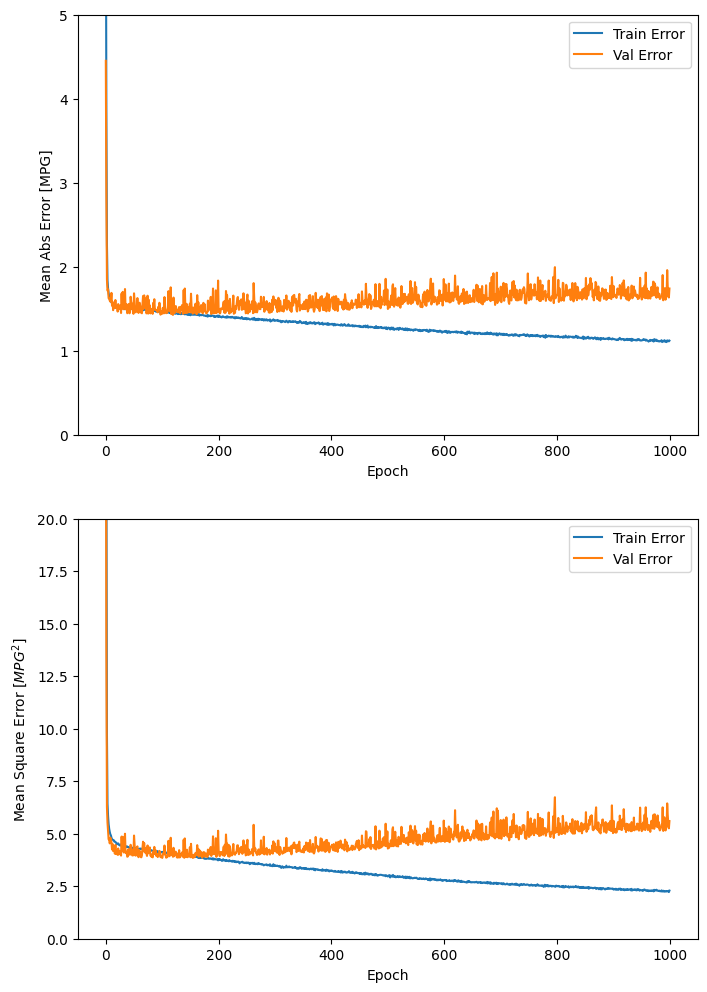

In [148]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

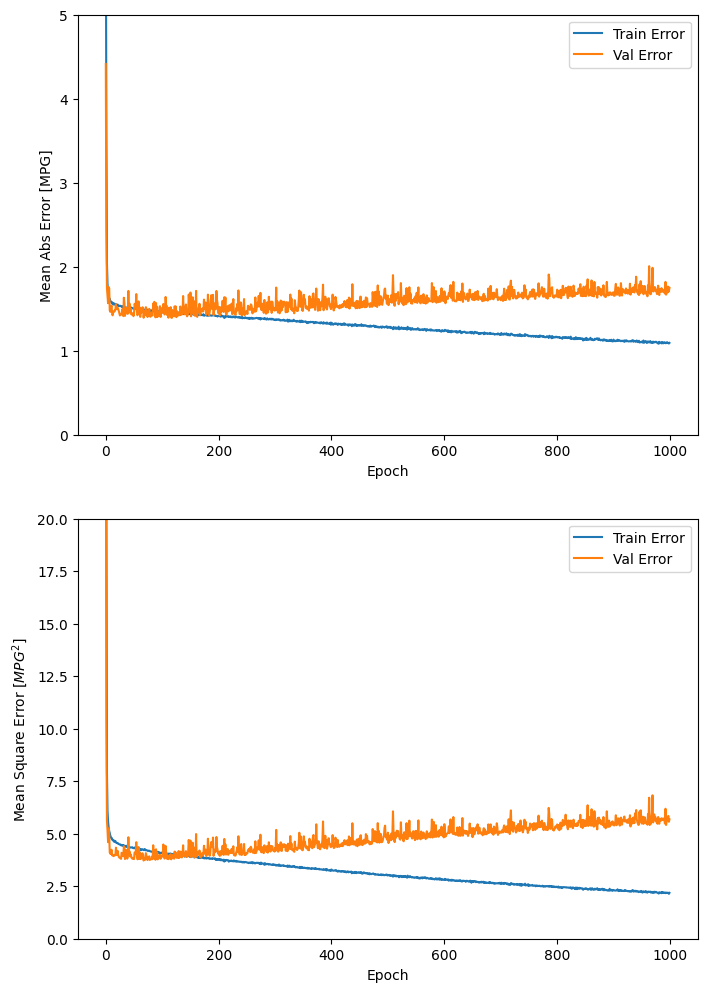

In [153]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# # 최적화 모델을 업데이트하고 저장합니다.
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelpath="./bestmodel.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[checkpointer,PrintDot()])

plot_history(history)

In [154]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

21/21 - 0s - loss: 7.2254 - mae: 1.8064 - mse: 7.2254 - 199ms/epoch - 9ms/step
테스트 세트의 평균 절대 오차:  1.81 MPG


In [155]:
from tensorflow import keras
model2 = keras.models.load_model(modelpath)
loss, mae, mse = model2.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

21/21 - 0s - loss: 6.5723 - mae: 1.5449 - mse: 6.5723 - 128ms/epoch - 6ms/step
테스트 세트의 평균 절대 오차:  1.54 MPG
